# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset, random_split

# Libraries to manipulate images
import PIL
from PIL import Image

from jupyterthemes import jtplot
jtplot.style()

# GPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Dataset and Dataloader

In [3]:
PATH =             r'Your path'
TRAIN_PATH =       r'Your path'
TRAIN_MASKS_PATH = r'Your path'
TEST_PATH =        r'Your path'

# Dataset

In [4]:
os.listdir(TRAIN_PATH)

['00087a6bd4dc_01.jpg',
 '00087a6bd4dc_02.jpg',
 '00087a6bd4dc_03.jpg',
 '00087a6bd4dc_04.jpg',
 '00087a6bd4dc_05.jpg',
 '00087a6bd4dc_06.jpg',
 '00087a6bd4dc_07.jpg',
 '00087a6bd4dc_08.jpg',
 '00087a6bd4dc_09.jpg',
 '00087a6bd4dc_10.jpg',
 '00087a6bd4dc_11.jpg',
 '00087a6bd4dc_12.jpg',
 '00087a6bd4dc_13.jpg',
 '00087a6bd4dc_14.jpg',
 '00087a6bd4dc_15.jpg',
 '00087a6bd4dc_16.jpg',
 '02159e548029_01.jpg',
 '02159e548029_02.jpg',
 '02159e548029_03.jpg',
 '02159e548029_04.jpg',
 '02159e548029_05.jpg',
 '02159e548029_06.jpg',
 '02159e548029_07.jpg',
 '02159e548029_08.jpg',
 '02159e548029_09.jpg',
 '02159e548029_10.jpg',
 '02159e548029_11.jpg',
 '02159e548029_12.jpg',
 '02159e548029_13.jpg',
 '02159e548029_14.jpg',
 '02159e548029_15.jpg',
 '02159e548029_16.jpg',
 '03a857ce842d_01.jpg',
 '03a857ce842d_02.jpg',
 '03a857ce842d_03.jpg',
 '03a857ce842d_04.jpg',
 '03a857ce842d_05.jpg',
 '03a857ce842d_06.jpg',
 '03a857ce842d_07.jpg',
 '03a857ce842d_08.jpg',
 '03a857ce842d_09.jpg',
 '03a857ce842d_1

In [5]:
# Creating our own Dataset
class Car_Dataset(Dataset):
    '''
    data: Train data path 
    masks: Train masks path (Masks are other images .gif)
    '''
    def __init__(self, data, masks=None, img_transforms=None, mask_transforms=None):
        
        self.train_data = data
        self.train_masks = masks
        
        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms
                
        self.images = sorted(os.listdir(self.train_data))
        self.masks = sorted(os.listdir(self.train_masks))

    # RETURN THE LEN FROM THE IMAGE LIST
    def __len__(self):
        if self.train_masks is not None:
            assert len(self.images) == len(self.masks), 'Different number of images'
        return len(self.images)
    
    # RETURN AN ELEMENT FROM THE DATASET AT THE SPECIFIED POSITION (idx)
    def __getitem__(self, idx):
        # The path where the images are located is concatenated with the name of the image you want to obtain.
        image_name = os.path.join(self.train_data, self.images[idx])
        # Load the image with a given path
        img = Image.open(image_name)        
        
        # Transformation that converts a PIL image or a NumPy array to a PyTorch tensor.
        trans = T.ToTensor()
        
        # If there is any transformation, this transformation is applied to the image
        if self.img_transforms:
            img = self.img_transforms(img)
        else:
            img = trans(img)
        
        # The mask (image, label) corresponding to said image is loaded
        if self.train_masks:
            mask_name = os.path.join(self.train_masks, self.masks[idx])
            mask = Image.open(mask_name)
            # If there is a transformation for the mask, it is applied to that mask.
            if self.mask_transforms:
                mask = self.mask_transforms(mask)
            else:
                mask = trans(mask)
            
            # NORMALIZATION OF THE MASK
            # The largest value is selected, possibly 255. mask has the 'max' property because it is a tensor
            mask_max = mask.max().item()
            
            # Divide the mask value by the largest value
            mask /= mask_max
        
        # If there is no mask, only the image is returned
        else:
            return img
        
        # The output of the function if a mask exists, it will be the image and the mask already transformed
        return img, mask

# Transformations

In [6]:
# Modify the image size
transform_data = T.Compose([
    T.Resize([224, 224]),
    T.ToTensor()
])

# Dataloaders

In [7]:
full_dataset = Car_Dataset(TRAIN_PATH,
                          TRAIN_MASKS_PATH,
                          img_transforms=transform_data,
                          mask_transforms=transform_data)

In [8]:
len(full_dataset)

5088

In [9]:
BATCH_SIZE = 32

# 80% of the data is calculated to obtain the number of images in TRAIN_SIZE
TRAIN_SIZE = int(len(full_dataset) * 0.8)

# The TRAIN_SIZE (80% of the total data) is subtracted minus the total data. Which gives us approximately 
# 20% of the total data, which will be the number of images for the VAL_SIZE  
VAL_SIZE = len(full_dataset) - TRAIN_SIZE

In [10]:
print(TRAIN_SIZE, VAL_SIZE)

4070 1018


In [11]:
train_dataset, val_dataset = random_split(full_dataset, [TRAIN_SIZE, VAL_SIZE])

In [12]:
print(len(train_dataset), len(val_dataset))

4070 1018


In [13]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
imgs, masks = next(iter(train_loader))
print(imgs.shape, masks.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])


# Let us see the data

In [15]:
def plot_mini_batch(imgs, masks):
    plt.figure(figsize=(20, 10))
    for i in range(BATCH_SIZE):
        
        plt.subplot(4, 8, i+1)
        # The position of the channels is changed and transformed to numpy to be able to graph them
        img = imgs[i,...].permute(1, 2, 0).numpy()
        # The same process is carried out for the masks.
        mask = masks[i, ...].permute(1, 2, 0).numpy()
                
        plt.imshow(img)       
        # The mask is shown but its opacity is reduced so that it can be superimposed on the image.
        plt.imshow(mask, alpha=0.4)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

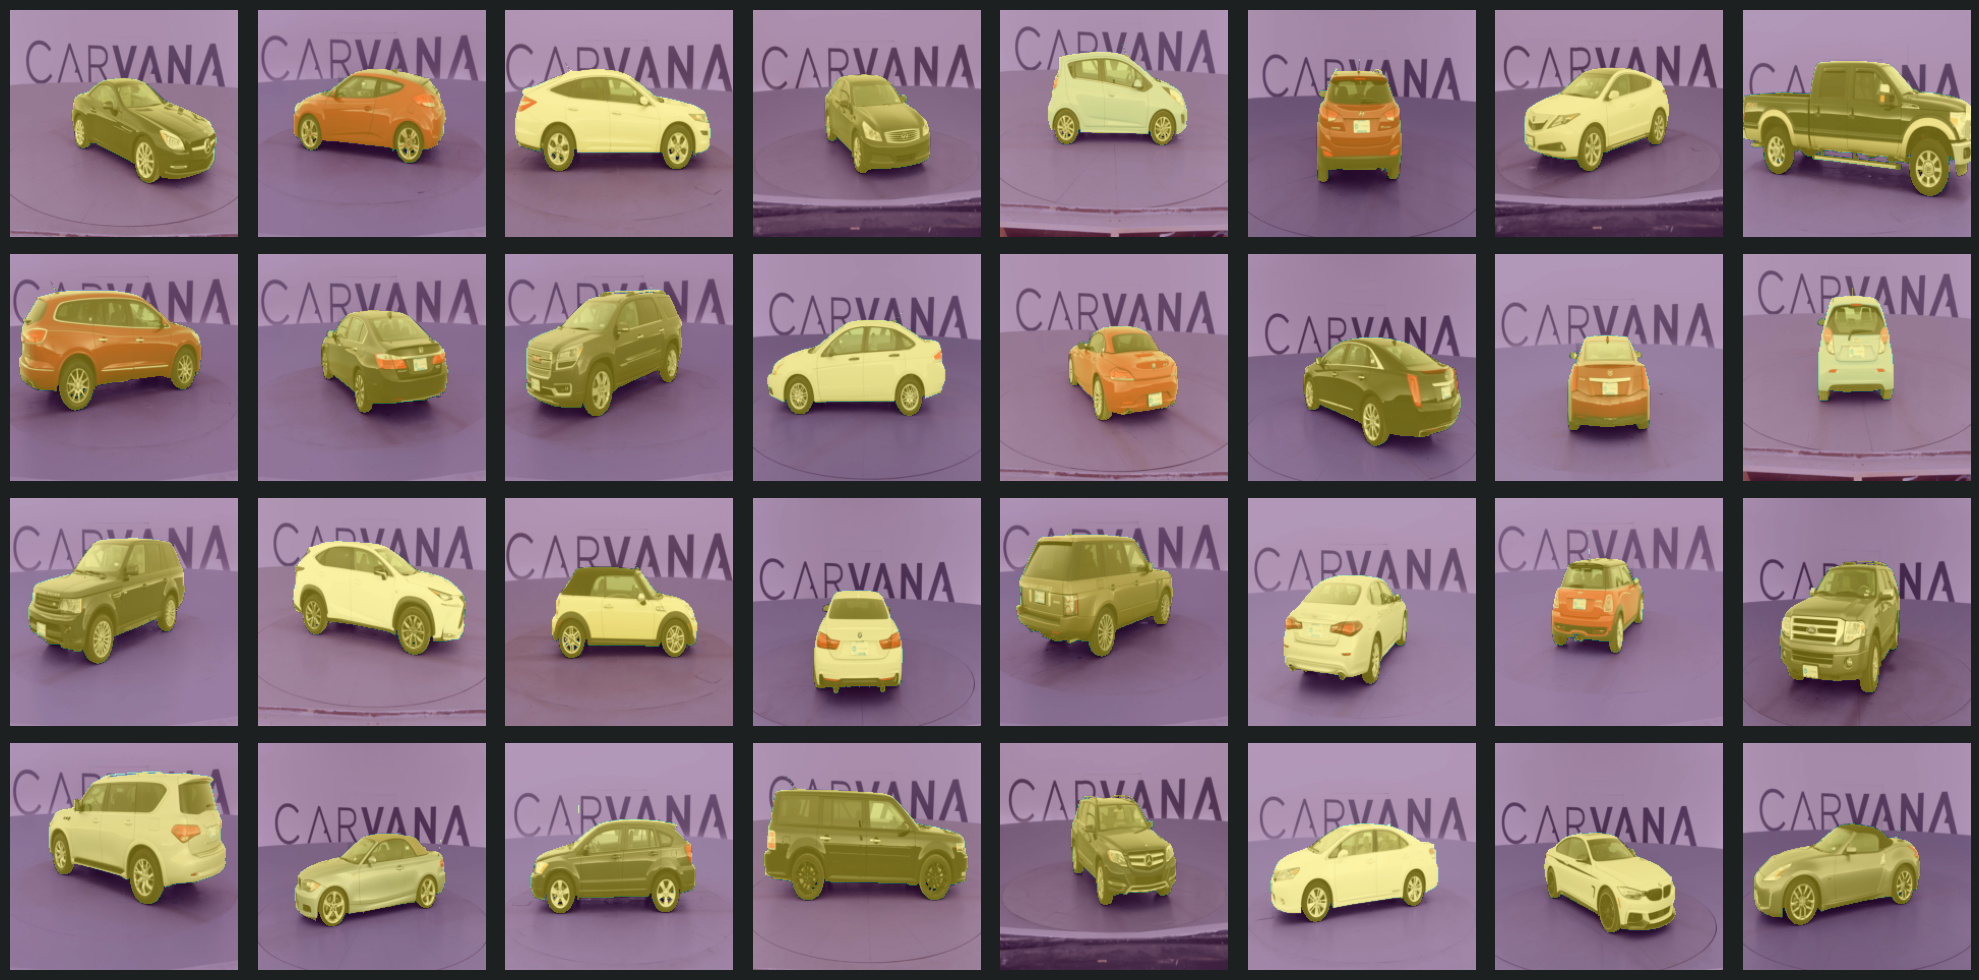

In [16]:
plot_mini_batch(imgs, masks)

# Accuracy

Intersection over Union (IoU) is used to calculate Accuracy.  
Which, as its name indicates, the intersection of all the predictions for each class is calculated (in this case there are only two classes), then the Union of all the predictions is carried out so that finally the division of the intersection between the union is carried out.

To calculate the Dice Coefficient, the intersection of all the predictions for each class is calculated (in this case there are only two) and then the sum of each of the predictions is calculated. The result of the intersection is multiplied by two and then divided by the sum of the predictions.  
Mathematically, it is written as:  
Dice coefficient = 2 * |A ∩ B| / (|A| + |B|)

In [17]:
def accuracy(model, loader):
    correct = 0
    intersection = 0
    denom = 0
    union = 0
    # Total elements that are being calculated correctly
    total = 0
    cost = 0.
    model = model.to(device=device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long).squeeze(1)
            # The scores are obtained
            scores = model(x)
            
            # The cost function (cross entropy) tells us how well the model is predicting.
            cost += (F.cross_entropy(scores, y)).item()
            
            # STANDARD ACCUARACY -NOT OPTIMAL-
            preds = torch.argmax(scores, dim=1)
            correct += (preds == y).sum()
            total += torch.numel(preds)
            
            # DICE COEFFICIENT            
            '''
            For the intersection, an element multiplication is performed between the predictions (preds)
            and the real value (y). The result of the multiplication will give values of 0 and 1, where 
            1 corresponds to a correct prediction. Hence, when the addition is made, only the correct 
            predictions (1) are being added and logically the model errors (0) do not contribute 
            to the sum.
            '''
            intersection += (preds*y).sum()
            denom += (preds + y).sum()            
            dice = (2 * intersection) / (denom)
            
            # INTERSECTION OVER UNION
            union += (preds + y - preds * y).sum()            
            iou = (intersection) / (union)                        
            
        return cost/len(loader), float(correct)/total, dice, iou

In [18]:
len(train_loader)

128

# Search for learning rate

Epochs are not used because One Cycle Policy is used

In [19]:
def find_lr(model, optimizer, start_val = 1e-6, end_val = 1, beta = 0.99, loader = train_loader):
    # Number of mini batches in the DataLoader (minus 1 because the first one counts as 0)
    # This avoids division by zero.
    n = len(loader) - 1
    
    # The factor is calculated which is calculated with the min and max value of the lr. 
    # The max value is divided by the min and the result is raised to 1/Total minibatches
    # It is the value that allows us to increase the lr
    factor = (end_val / start_val)**(1/n)
    
    # The lr is initialized with the min value.
    lr = start_val
    
    # The lr parameter of the optimizer is accessed and updated with the lr value
    optimizer.param_groups[0]['lr'] = lr #this allows you to update the learning rate
    
    # The values of average loss, loss and precision are initialized.
    avg_loss, loss, acc = 0., 0., 0.
    
    # The value of the lowest loss is initialized
    lowest_loss = 0.
    
    # The value of the current mini batch is initialized
    batch_num = 0
    
    # Lists are created to store the progress of 'loss', 'lr', 'precision' respectively
    losses = []
    log_lrs = []
    accuracies = []
    
    
    model = model.to(device=device)
    
    # To avoid division by zero, the index starts at 1
    for i, (x, y) in enumerate(loader, start=1):
        # Data is uploaded to the available device (GPU/CPU)
        x = x.to(device = device, dtype = torch.float32)
        y = y.to(device = device, dtype = torch.long).squeeze(1)
        
        # Gradients are emptied so they do not accumulate
        optimizer.zero_grad()
        # Predictions are obtained for each minibatch
        scores = model(x)
        # The cost of the model is calculated
        cost = F.cross_entropy(input=scores, target=y)
        
        # EWMA IMPLEMENTATION (Exponentially Weighted Moving Average)    
        loss = beta*loss + (1-beta)*cost.item()
        
        #bias correction
        avg_loss = loss/(1 - beta**i)
        
        preds = torch.argmax(scores, dim=1)
        acc_ = (preds == y).sum()/torch.numel(scores)
#         acc = beta*acc + (1-beta)*acc_.item()
#         avg_acc = acc/(1 - beta**i)
        
        #If loss is massive stop                
        if i > 1 and avg_loss > 4 * lowest_loss:
            print(f'from here{i, cost.item()}')
            return log_lrs, losses, accuracies
        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss

        accuracies.append(acc_.item())
#         accuracies.append(avg_acc)
        losses.append(avg_loss)
        log_lrs.append(lr)
        #step
        cost.backward()
        optimizer.step()
        #update lr
        print(f'cost:{cost.item():.4f}, lr: {lr:.4f}, acc: {acc_.item():.4f}')
        lr *= factor
        optimizer.param_groups[0]['lr'] = lr
        
    return log_lrs, losses, accuracies     

# Train loop

In [20]:
def train(model, optimizer, scheduler=None, epochs=100, store_every=25):
    model = model.to(device=device)
    for epoch in range(epochs):
        train_correct_num = 0
        train_total = 0
        train_cost_acum = 0.
        for mb, (x, y) in enumerate(train_loader, start=1):
            model.train()
            x = x.to(device=device, dtype=torch.float32)            
            y = y.to(device=device, dtype=torch.long).squeeze(1)
            
            # The scores are obtained
            # Get a tensor with the shape: [batch_size, channels, height, width]            
            scores = model(x)            
            
            # Cost function calculation 
            cost = F.cross_entropy(input=scores, target=y)
            optimizer.zero_grad()
            
            # Model gradients are calculated with Backpropagation
            cost.backward()
                        
            # The model parameters are updated with the previously calculated gradients.
            optimizer.step()
                                    
            # The learning rate (and momentum if specified) is adjusted during the training process.
            # It is worth mentioning that this updates the learning rate of the optimizer.
            if scheduler: scheduler.step()
                                            
            train_predictions = torch.argmax(scores, dim=1)            
            # Correct predictions are counted and accumulated with the following iterations
            train_correct_num += (train_predictions == y).sum()            
            
            # The total number of elements is counted and accumulated with the following iterations
            train_total += torch.numel(train_predictions)
                                    
            # The cost of the tensor is obtained and added with the following iterations
            train_cost_acum += cost.item()
            
            
            '''
            The validation Accuracy takes all the elements of the validation set, so this takes a long 
            time, which is why it is only calculated every 25 iterations instead of every iteration.
            '''
            if mb%store_every == 0:
                val_cost, val_acc, dice, iou = accuracy(model, val_loader)
                train_acc = float(train_correct_num)/train_total
                train_cost_every = float(train_cost_acum)/mb # Se normaliza
                print(f'mb: {mb}, train cost: {train_cost_every:.4f}, val cost: {val_cost:.4f}',
                      f'train acc: {train_acc:.4f}, val acc: {val_acc:.4}',
                      f'dice: {dice}, iou: {iou}')
                print()

# U-NET Model

![U-NET Architecture](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [21]:
class Conv_k3(nn.Module):
    '''
    Create a convolution with stride=1, padding=1 and a kernel of 3.    
    With a kernel_size of 3 and a padding of 1, the input_size is maintained (it still has the same size)    
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.conv1 = nn.Conv2d(channels_in, channels_out, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels_out)
        
    def forward(self, x):
        return self.bn1(self.conv1(x))

In [22]:
class Double_Conv(nn.Module):
    '''
    Class responsible for creating a two-convolution block
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.double_conv = nn.Sequential(
                            Conv_k3(channels_in, channels_out),
                            #nn.BatchNorm2d(channels_out))
                            nn.ReLU(),
                            Conv_k3(channels_out, channels_out),
                            nn.ReLU())
    
    def forward(self, x):
        return self.double_conv(x)    

In [23]:
class Down_Conv(nn.Module):
    '''
    Class responsible for extracting main features of the image. 
    It is also responsible for reducing the size of the image.
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.encoder = nn.Sequential(
                            nn.MaxPool2d(2),
                            Double_Conv(channels_in, channels_out))
    
    def forward(self, x):
        return self.encoder(x)

In [24]:
class Up_Conv(nn.Module):
    '''
    In the paper it indicates the up-conv as a Transposed Convolution.
    In this case it will be replaced by up-sampling followed by a 1x1 Convolution.
    The Up-Sample will make the image larger (increases the width and height of the image), in this way, 
    more information can be obtained                            
    '''
    def __init__(self, channels_in):
        super().__init__()
        self.upsample_layer = nn.Sequential(
                                nn.Upsample(scale_factor=2, mode='bicubic'),
                                nn.Conv2d(in_channels=channels_in,             
                                          out_channels=(channels_in//2),
                                          kernel_size=1))
        '''
        Following the architecture of the paper. After performing the upsampling, two convolutions are 
        performed where the same number of filters is applied in both convolutions, 
        ambas convoluciones se aplica la misma cantidad de filtros, this reduces the volume of the input.                
        '''        
        self.decoder = Double_Conv(channels_in, (channels_in//2)) 
    
    '''    
    x1: Outsampling output
    x2: Downsampling output
    '''
    def forward(self, x1, x2):
        x1 = self.upsample_layer(x1)        
        x = torch.cat([x2, x1], dim=1)        
        return self.decoder(x)        

In [25]:
class UNET(nn.Module):
    '''
    Class responsible for implementing the entire U-NET architecture process.
    '''
    def  __init__(self, channels_in, channels, num_classes):
        super().__init__()
        # ********** DOWN SAMPLING **********
        self.first_conv = Double_Conv(channels_in, channels) # 64 x 224 x 224
        self.ds1 = Down_Conv(channels, channels*2) # 128 x 112 x 112        
        self.ds2 = Down_Conv(channels*2, channels*4)  # 256 x 56 x 56        
        self.ds3 = Down_Conv(channels*4, channels*8)   # 512 x 28 x 28
        
        '''
        This is the output that is in the middle of the entire process.
        From this point the Up Sample process begins.        
        '''        
        self.middle_conv = Down_Conv(channels*8, channels*16)  # 1024 x 14 x 14
        
        # ********** UP SAMPLING **********        
        self.us1 = Up_Conv(channels_in = channels*16) # 512 x 28 x 28        
        self.us2 = Up_Conv(channels_in = channels*8)  # 256 x 56 x 56        
        self.us3 = Up_Conv(channels_in = channels*4)  # 128 x 112 x 112        
        self.us4 = Up_Conv(channels_in = channels*2)  # 64 x 224 x 224 
        
        
        '''
        This is the LAST convolution that is defined in the architecture.
        In this convolution the output volume represents each of the classes that we want to identify.
        A kernel of 1 is being applied so the output size will not be modified. Only the output volume 
        will change.                
        '''
        self.last_conv = nn.Conv2d(in_channels=channels, out_channels=num_classes, kernel_size=1)
        
    def forward(self, x):
        x1 = self.first_conv(x)
        x2 = self.ds1(x1)
        x3 = self.ds2(x2)
        x4 = self.ds3(x3)
        
        x5 = self.middle_conv(x4)
        
        u1 = self.us1(x5, x4)
        u2 = self.us2(u1, x3)
        u3 = self.us3(u2, x2)
        u4 = self.us4(u3, x1)
        
        return self.last_conv(u4)        

# Train Model

In [26]:
# Define the model and look for learning rate
torch.manual_seed(4)
model = UNET(3, 4, 2)
optimizer_unet = torch.optim.SGD(model.parameters(),
                                lr=0.01, momentum=0.95,
                                weight_decay=1e-4)
lg_lr, losses, accuracies = find_lr(model, optimizer_unet, start_val=1e-6, end_val=10)

cost:0.6908, lr: 0.0000, acc: 0.3657
cost:0.6909, lr: 0.0000, acc: 0.3696
cost:0.6894, lr: 0.0000, acc: 0.3732
cost:0.6927, lr: 0.0000, acc: 0.3687
cost:0.6912, lr: 0.0000, acc: 0.3662
cost:0.6926, lr: 0.0000, acc: 0.3651
cost:0.6916, lr: 0.0000, acc: 0.3687
cost:0.6901, lr: 0.0000, acc: 0.3696
cost:0.6906, lr: 0.0000, acc: 0.3668
cost:0.6908, lr: 0.0000, acc: 0.3689
cost:0.6905, lr: 0.0000, acc: 0.3713
cost:0.6898, lr: 0.0000, acc: 0.3640
cost:0.6887, lr: 0.0000, acc: 0.3754
cost:0.6909, lr: 0.0000, acc: 0.3658
cost:0.6909, lr: 0.0000, acc: 0.3696
cost:0.6903, lr: 0.0000, acc: 0.3717
cost:0.6902, lr: 0.0000, acc: 0.3638
cost:0.6908, lr: 0.0000, acc: 0.3680
cost:0.6897, lr: 0.0000, acc: 0.3676
cost:0.6902, lr: 0.0000, acc: 0.3740
cost:0.6899, lr: 0.0000, acc: 0.3667
cost:0.6887, lr: 0.0000, acc: 0.3704
cost:0.6894, lr: 0.0000, acc: 0.3709
cost:0.6893, lr: 0.0000, acc: 0.3695
cost:0.6892, lr: 0.0000, acc: 0.3686
cost:0.6895, lr: 0.0000, acc: 0.3685
cost:0.6908, lr: 0.0000, acc: 0.3655
c

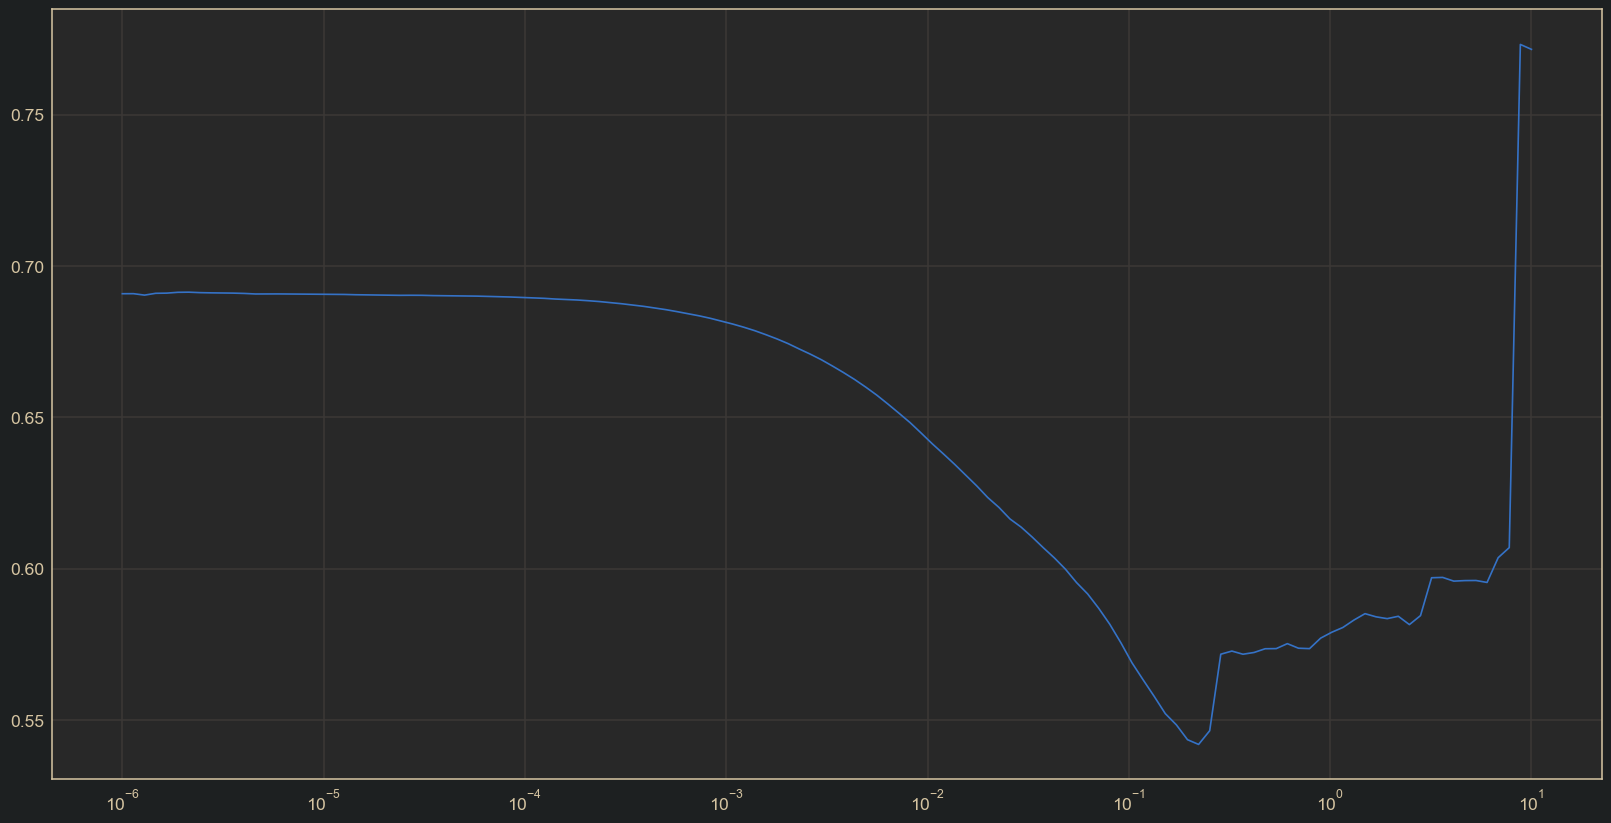

In [27]:
# Plot loss vs Learning Rate
f1, ax1 = plt.subplots(figsize=(20, 10))
ax1.plot(lg_lr, losses)
ax1.set_xscale('log')
plt.show()

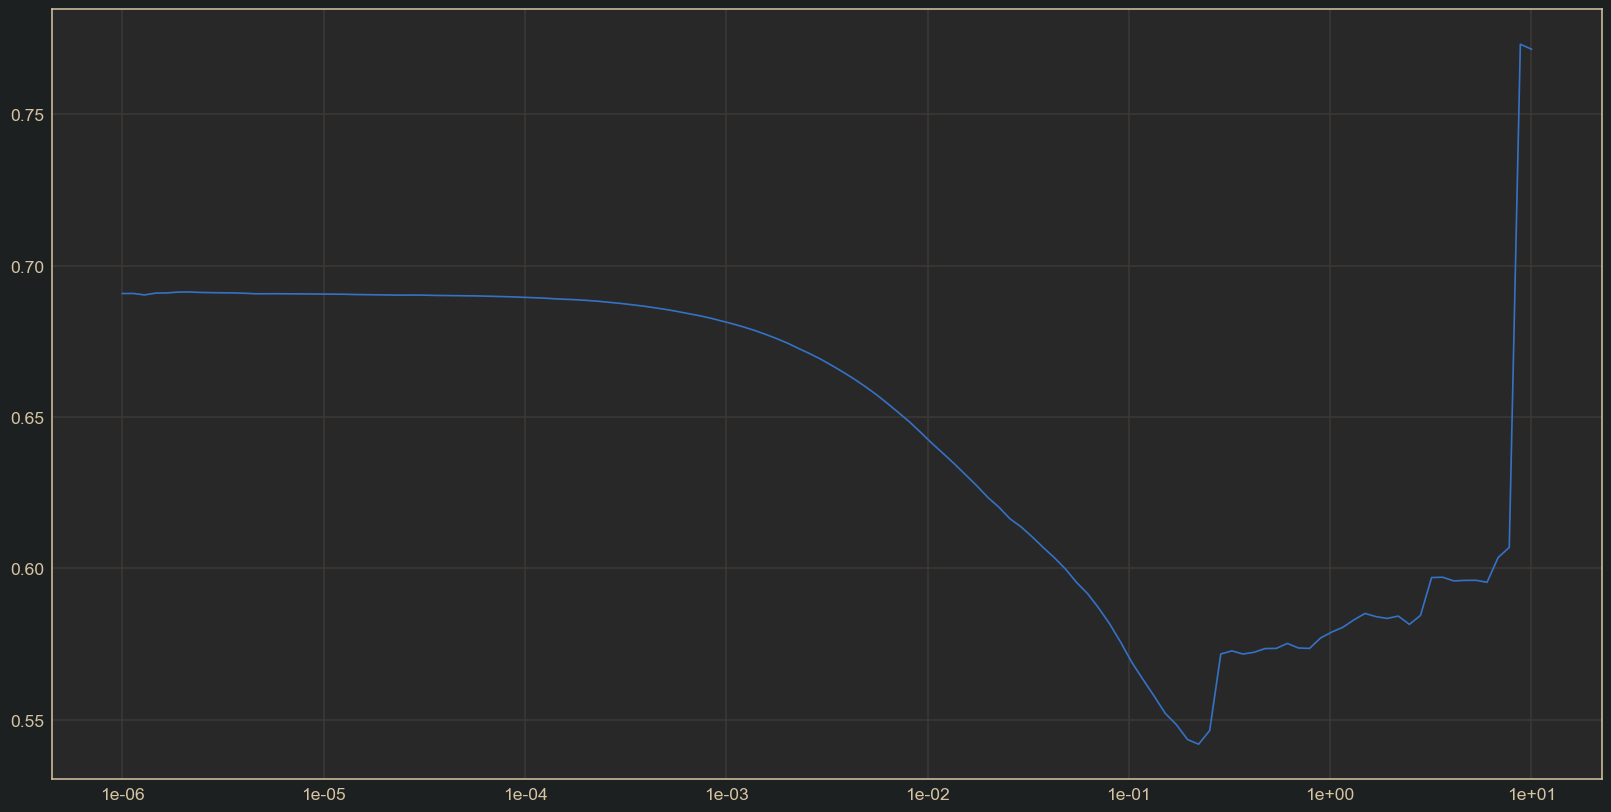

In [28]:
from matplotlib.ticker import ScalarFormatter, StrMethodFormatter
f1, ax1 = plt.subplots(figsize=(20, 10))
ax1.plot(lg_lr, losses)
ax1.set_xscale('log')
ax1.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.xaxis.offsetText.set_fontsize(14)
ax1.xaxis.set_major_formatter(StrMethodFormatter('{x:.0e}'))
plt.show()

In [29]:
# Define the model and train with scheduler
torch.manual_seed(4)
epochs=1
model = UNET(3, 4, 2)
# Define the optimizer, the learning rate is not very relevant because it will be updated with the scheduler.
optimizer_unet = torch.optim.SGD(model.parameters(),
                                lr=0.01, momentum=0.95,
                                weight_decay=1e-4)

# Define the scheduler. Max_lr is obtained from the plot above.
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer_unet,
                                                max_lr = 1e-1,
                                                steps_per_epoch=len(train_loader),
                                                epochs=epochs, pct_start=0.43, div_factor=10,
                                                final_div_factor=1000,
                                                three_phase=True,
                                                cycle_momentum=True)

In [30]:
train(model, optimizer_unet, scheduler, epochs)

mb: 25, train cost: 0.5121, val cost: 0.3064 train acc: 0.7932, val acc: 0.8421 dice: 0.4065934419631958, iou: 0.2551724314689636

mb: 50, train cost: 0.3312, val cost: 0.0873 train acc: 0.8656, val acc: 0.9639 dice: 0.9175620079040527, iou: 0.8476809859275818

mb: 75, train cost: 0.2401, val cost: 0.0420 train acc: 0.9029, val acc: 0.9844 dice: 0.9627902507781982, iou: 0.9282503128051758

mb: 100, train cost: 0.1901, val cost: 0.0353 train acc: 0.9233, val acc: 0.9865 dice: 0.9680677652359009, iou: 0.9381119012832642

mb: 125, train cost: 0.1593, val cost: 0.0342 train acc: 0.9359, val acc: 0.9871 dice: 0.9693385362625122, iou: 0.94050133228302



# Plot some test images 

In [31]:
# A dataset is created with new images
test_dataset = Car_Dataset(TEST_PATH, None, transform_data, None)

In [33]:
# A loader is created with the new test data
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [37]:
imgs_test = next(iter(test_loader))
print(imgs_test.shape)

torch.Size([32, 3, 224, 224])


In [38]:
# Predictions are made with images that the model has never seen
imgs_test_to = imgs_test.to(device, dtype=torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_test_to)
    preds = torch.argmax(scores, dim=1).float()

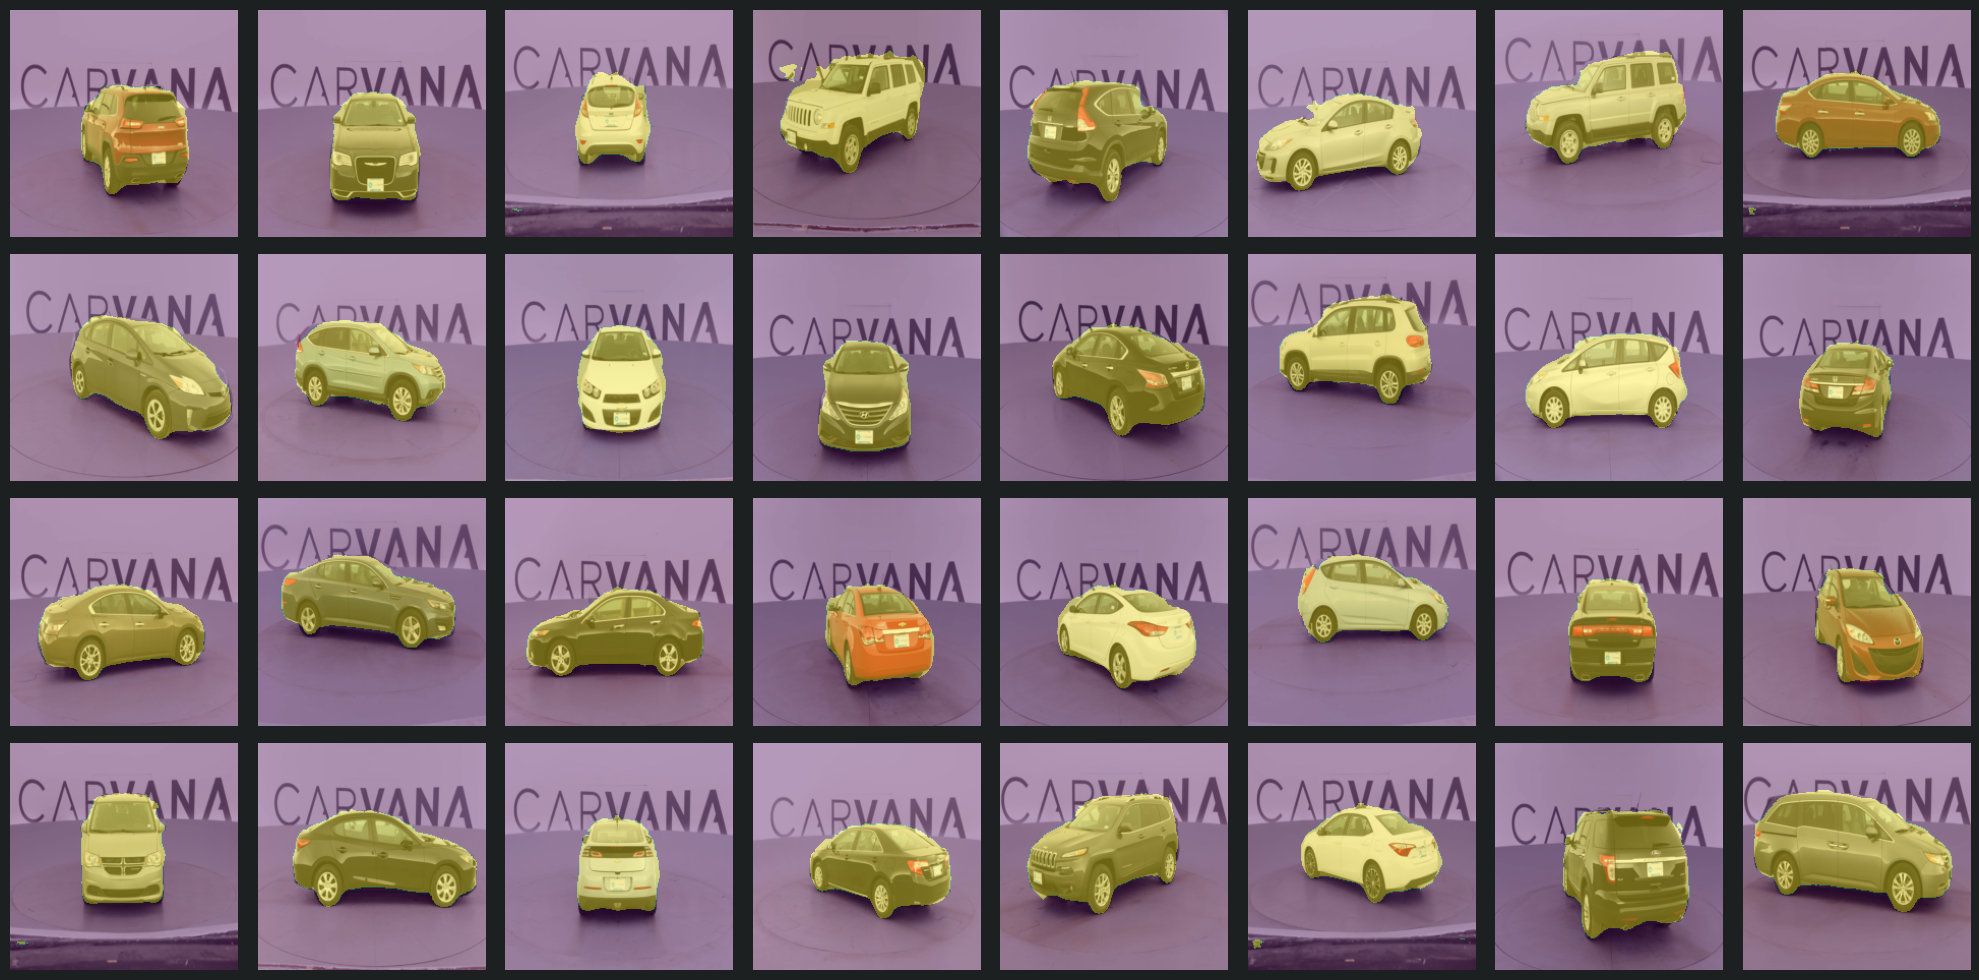

In [39]:
# The prediction is uploaded to the CPU to be able to graph these values
preds = preds.cpu().unsqueeze(1)
plot_mini_batch(imgs_test, preds)